In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import scipy
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr

In [2]:
kul = sc.read_h5ad("melanoma-ribas_Seurat_KUL_cohort_data_KUL_cohort_merged_v2.h5ad")

In [3]:
kul_status = pd.read_csv("table_KUL_cohort_clone_bc_info.csv")

In [4]:
obs = kul.obs
kul = kul[obs[obs["celltype_bped_main"]=="Melanocytes"].index]
obs = kul.obs

In [9]:
len(np.unique(kul.obs["patient_ID"]))

23

In [5]:
wouters = pd.read_csv("wouters_mel_sigs.csv")

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/1428436661.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,2

In [15]:
status = []
subs_adata = []
counter=0
for i in obs.index:
    if counter%1000==0:
        print(counter)
    if obs.loc[i]["sample"] in list(kul_status["sample"]):
        tmp = kul_status[kul_status["sample"]==obs.loc[i]["sample"]]
        tmp.index = [j.split("-")[0] for j in tmp["cell"]]
        if i.split("-")[0] in list(tmp.index):
            status.append(tmp.loc[i.split("-")[0]]["status"])
            subs_adata.append(i)
    counter+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000


In [16]:
kul = kul[subs_adata, :]
kul.obs["status"] = status

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_54465/3337295047.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  kul.obs["status"] = status


In [17]:
#kul.X = kul.layers["counts"]
sc.pp.calculate_qc_metrics(kul, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# by scanpy in subsequent filtering steps
kul.obs['original_total_counts'] = kul.obs['total_counts']

# log10 original library size
kul.obs['log10_original_total_counts'] = np.log10(kul.obs['original_total_counts'])

# Normalize by median library size
med = np.median(kul.obs['original_total_counts'])
sc.pp.normalize_total(kul, target_sum = med)
sc.pp.log1p(kul)

In [18]:
sc.pp.neighbors(kul)
sc.tl.umap(kul)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [19]:
sig = pd.read_csv("mel_expansion_contraction_sigs_shared2p.csv", index_col=0)
sig.index = sig['0']

In [20]:
exp_sig = sig[sig["source"]=="growing"].index
cont_sig = sig[sig["source"]=="shrinking"].index

In [21]:
kul.obs["expansion_hotspot_sig"] = kul.to_df()[exp_sig].mean(axis=1)

In [22]:
kul.obs["contraction_hotspot_sig"] = kul.to_df()[cont_sig].mean(axis=1)

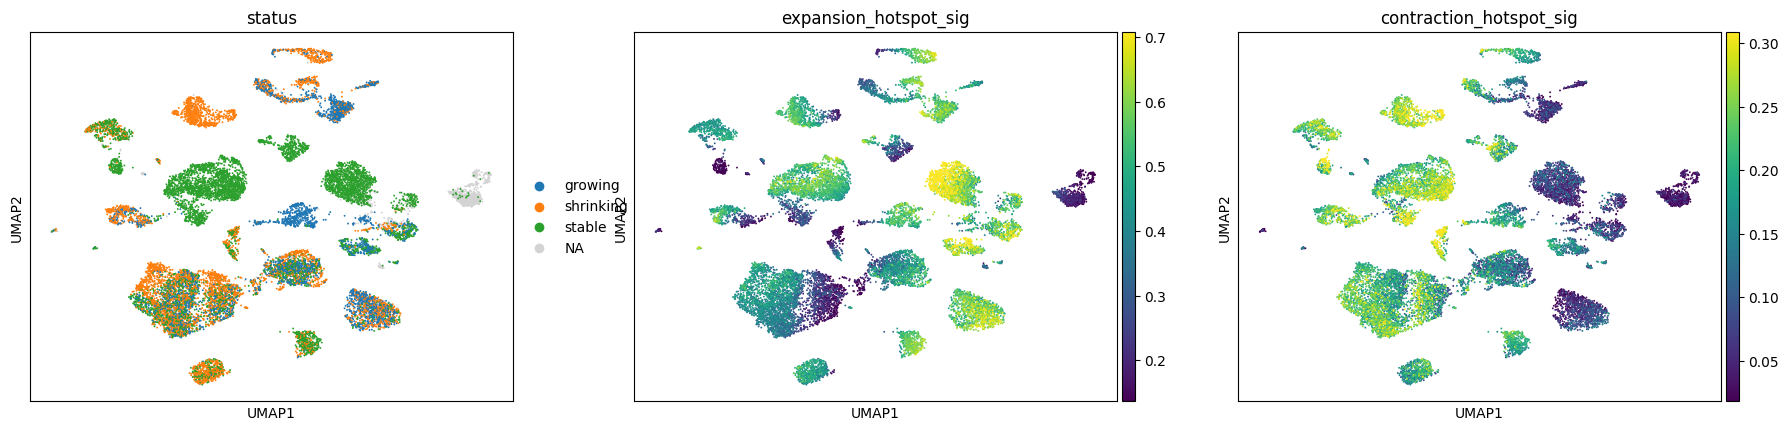

In [18]:
#top shared intrinsic
sc.pl.umap(kul, color=['status', "expansion_hotspot_sig", "contraction_hotspot_sig"], vmax='p98', vmin='p05')

In [23]:
mel = sc.read_h5ad("adata_nr_latest.h5")

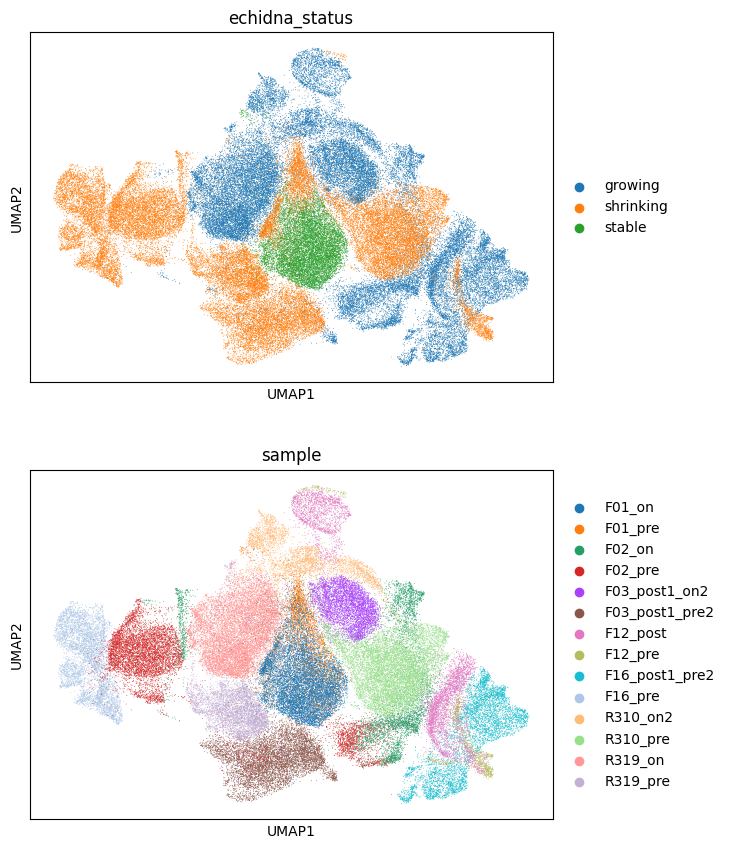

In [109]:
sc.pl.umap(mel, color=["echidna_status",'sample'], ncols=1, save="2b.pdf")

In [24]:
obs = kul.obs
kul_expanding = kul.to_df().loc[obs[obs["status"]=="growing"].index]
kul_shrinking = kul.to_df().loc[obs[obs["status"]=="shrinking"].index]

obs = mel.obs
mel_expanding = mel.to_df().loc[obs[obs["echidna_status"]=="growing"].index]
mel_shrinking = mel.to_df().loc[obs[obs["echidna_status"]=="shrinking"].index]

In [27]:
def stats(sigs, growing_sig, mel_expanding, mel_shrinking, kul_expanding, kul_shrinking):
    lfc_mel = pd.DataFrame()
    for gene in sigs:
        if not np.isnan(scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])[1]):
            lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
    
    print(lfc_mel.shape)
    lfc_kul = pd.DataFrame()
    for gene in sigs:
        if not np.isnan(scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])[1]):
            lfc_kul[gene] = scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])
    lfc_mel = lfc_mel.T
    lfc_mel.columns = ['stat','p-val']
    lfc_kul = lfc_kul.T
    lfc_kul.columns = ['stat','p-val']
    
    _, p_bonf, _, _ = multipletests(lfc_mel["p-val"], method='fdr_bh')
    lfc_mel["p-val-adj"] = p_bonf
    
    _, p_bonf, _, _ = multipletests(lfc_kul["p-val"], method='fdr_bh')
    lfc_kul["p-val-adj"] = p_bonf

    lfc_mel = lfc_mel[lfc_mel["p-val-adj"]<.05]
    lfc_kul = lfc_kul[lfc_kul["p-val-adj"]<.05]
    
    lfc_mel = lfc_mel.loc[np.intersect1d(lfc_mel.index, lfc_kul.index)]
    lfc_kul = lfc_kul.loc[np.intersect1d(lfc_mel.index, lfc_kul.index)]
    
    color = []
    for g in lfc_mel.index:
        if g in growing_sig:
            color.append("pink")
        else:
            color.append("teal")
    return lfc_mel, lfc_kul, color

In [28]:
sigs = list(sig.loc[np.intersect1d(sig, mel.var_names)].index)

lfc_mel, lfc_kul, color = stats(sigs, exp_sig, mel_expanding, mel_shrinking, kul_expanding, kul_shrinking)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_54465/2382890918.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_54465/2382890918.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_54465/2382890918.py:5: PerformanceWarning: DataFrame is highl

(2, 171)


/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_54465/2382890918.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_kul[gene] = scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_54465/2382890918.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_kul[gene] = scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_54465/2382890918.py:11: PerformanceWarning: DataFrame is hi

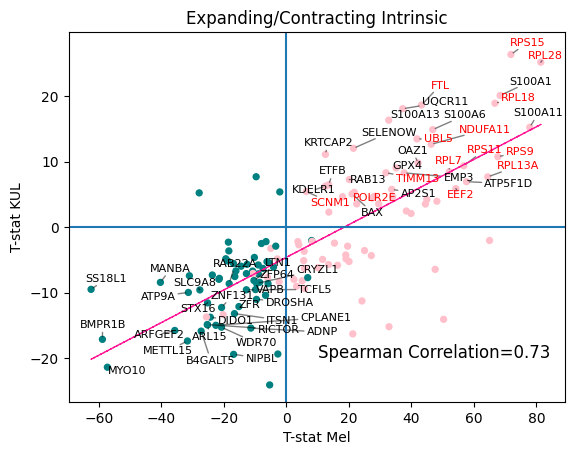

In [114]:
x = lfc_mel["stat"]
y = lfc_kul["stat"]
plt.scatter(x, y, s=18, c=color)

texts = []
for i in lfc_mel.index:
    if (lfc_mel.loc[i]['stat']>5 and lfc_kul.loc[i]['stat']>5 and i in exp_sig) or (lfc_mel.loc[i]['stat']<-8 and lfc_kul.loc[i]['stat']<-8 and i in cont_sig):
        if i in list(wouters["Immune_resistance_wang"]):
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='red'))
        else:
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black',alpha=.5))

coefficients = np.polyfit(x, y, 1)

spearman_corr, _ = spearmanr(x, y)

# Get the slope and intercept of the fitted line
slope, intercept = coefficients

# Create the line of best fit
y_fit = slope * x + intercept

plt.plot(x, y_fit, color="deeppink", label="Fitted Line", linewidth=1, linestyle="--")

plt.annotate("Spearman Correlation="+str(round(spearman_corr,2)), (10,-20), fontsize=12)


plt.axvline(0)
plt.axhline(0)
#plt.xlim([-80,85])
plt.title("Expanding/Contracting Intrinsic")
plt.xlabel("T-stat Mel")
plt.ylabel("T-stat KUL")
plt.savefig("mel_figures/2h_intrinsic.pdf")

In [115]:
sig = pd.read_csv("mel_expansion_contraction_sigs_top_ext.csv", index_col=0)
sig.index = sig['0']

In [116]:
exp_sig = sig[sig["source"]=="growing"].index
cont_sig = sig[sig["source"]=="shrinking"].index

In [117]:
sigs = list(sig.loc[np.intersect1d(sig, mel.var_names)].index)

lfc_mel, lfc_kul, color = stats(sigs, exp_sig, mel_expanding, mel_shrinking, kul_expanding, kul_shrinking)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:5: PerformanceWarning: DataFrame is highl

(2, 209)


/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_kul[gene] = scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_kul[gene] = scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:11: PerformanceWarning: DataFrame is hi

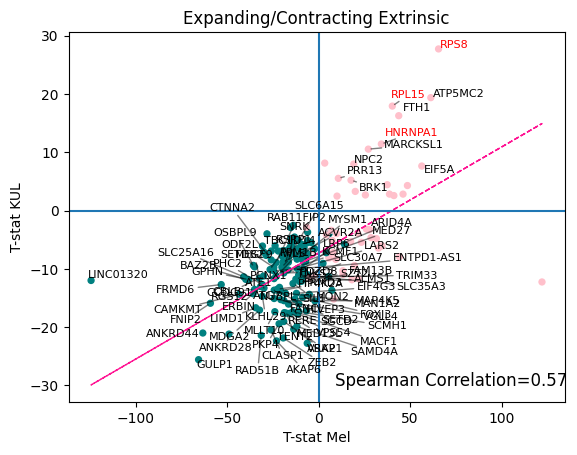

In [118]:
x = lfc_mel["stat"]
y = lfc_kul["stat"]
plt.scatter(x, y, s=18, c=color)

texts = []
for i in lfc_mel.index:
    if (lfc_mel.loc[i]['stat']>5 and lfc_kul.loc[i]['stat']>5 and i in exp_sig) or (lfc_mel.loc[i]['stat']<-8 and lfc_kul.loc[i]['stat']<-8 and i in cont_sig):
        if i in list(wouters["Immune_resistance_wang"]):
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='red'))
        else:
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black',alpha=.5))

coefficients = np.polyfit(x, y, 1)

spearman_corr, _ = spearmanr(x, y)

# Get the slope and intercept of the fitted line
slope, intercept = coefficients

# Create the line of best fit
y_fit = slope * x + intercept

plt.plot(x, y_fit, color="deeppink", label="Fitted Line", linewidth=1, linestyle="--")

plt.annotate("Spearman Correlation="+str(round(spearman_corr,2)), (9,-30), fontsize=12)


plt.axvline(0)
plt.axhline(0)
#plt.xlim([-80,85])
plt.title("Expanding/Contracting Extrinsic")
plt.xlabel("T-stat Mel")
plt.ylabel("T-stat KUL")
plt.savefig("mel_figures/2h_extrinsic.pdf")

In [25]:
sc.tl.rank_genes_groups(mel, groupby="echidna_status", method='wilcoxon')
deg = sc.get.rank_genes_groups_df(mel, group="growing").sort_values(by="logfoldchanges",ascending=True)
deg_growing = deg[deg["pvals_adj"]<.05]

deg_growing = deg_growing[deg_growing.logfoldchanges>0]
deg_gr_sig = deg_growing.sort_values(by='logfoldchanges', ascending=False).iloc[0:100]["names"]

deg = sc.get.rank_genes_groups_df(mel, group="shrinking").sort_values(by="logfoldchanges",ascending=True)
deg_shrinking = deg[deg["pvals_adj"]<.05]
deg_shrinking = deg_shrinking[deg_shrinking.logfoldchanges>0]
deg_sh_sig = deg_shrinking.sort_values(by='logfoldchanges', ascending=False).iloc[0:100]["names"]

deg_sig = list(deg_gr_sig) + list(deg_sh_sig)

In [26]:
deg_gr_sig = list(deg_gr_sig)
deg_sh_sig = list(deg_sh_sig)

In [47]:
lfc_mel, lfc_kul, color = stats(deg_sig, deg_gr_sig, mel_expanding, mel_shrinking, kul_expanding, kul_shrinking)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_4892/822006766.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_4892/822006766.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_4892/822006766.py:5: PerformanceWarning: DataFrame is highly frag

Text(35.472222222222214, 0.5, 'T-stat KUL')

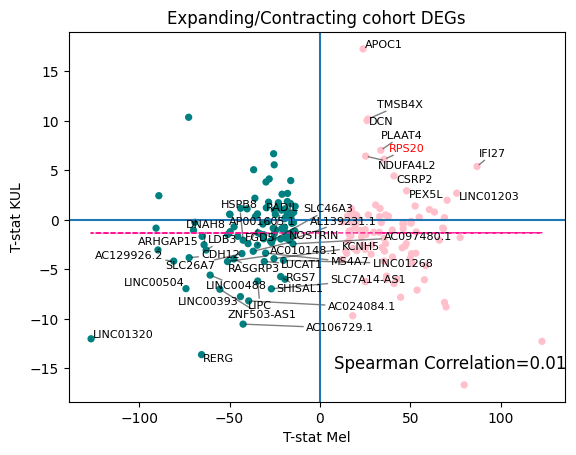

In [51]:
x = lfc_mel["stat"]
y = lfc_kul["stat"]
plt.scatter(x, y, s=18, c=color)

texts = []
for i in lfc_mel.index:
    if (lfc_mel.loc[i]['stat']>2 and lfc_kul.loc[i]['stat']>2 and i in deg_gr_sig) or (lfc_mel.loc[i]['stat']<-2 and lfc_kul.loc[i]['stat']<-2 and i in deg_sh_sig):
        if i in list(wouters["Immune_resistance_wang"]):
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='red'))
        else:
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black',alpha=.5))

coefficients = np.polyfit(x, y, 1)

spearman_corr, _ = spearmanr(x, y)

# Get the slope and intercept of the fitted line
slope, intercept = coefficients

# Create the line of best fit
y_fit = slope * x + intercept

plt.plot(x, y_fit, color="deeppink", label="Fitted Line", linewidth=1, linestyle="--")

plt.annotate("Spearman Correlation="+str(round(spearman_corr,2)), (8,-15), fontsize=12)


plt.axvline(0)
plt.axhline(0)
#plt.xlim([-80,85])
plt.title("Expanding/Contracting cohort DEGs")
plt.xlabel("T-stat Mel")
plt.ylabel("T-stat KUL")

In [36]:
import os
PATH = "hmm_all_pt/"
degs = {}
for patient in os.listdir(PATH):
    if "_" not in patient:
        print(patient)
        X = sc.read_h5ad(PATH+patient+"/"+patient+"_X.h5")
        if "growing" in np.unique(X.obs["echidna_status"]):
            var = X.X.var(axis=0)
            thresh = np.quantile(var, 0.75)
            gene_filter = var > thresh
            X = X[:, gene_filter]
            sc.tl.rank_genes_groups(X, groupby="echidna_status", method='wilcoxon')
            deg = sc.get.rank_genes_groups_df(X, group="growing").sort_values(by="logfoldchanges",ascending=False)
            deg.index = deg["names"]
            deg = deg[deg["pvals_adj"]<.05]
            deg = deg[deg["logfoldchanges"]>0]
            degs[patient] = deg.index
        else:
            print("No growing clusters")

F16


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F03


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F02


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F12


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


R310


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


R319


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F01
No growing clusters


In [37]:
all_hs_genes_flat = []
for i in list(degs.values()):
    all_hs_genes_flat+=list(i)
count_degs = pd.DataFrame(np.unique(all_hs_genes_flat, return_counts=True))
count_degs = count_degs.T

In [45]:
share_degs = count_degs[count_degs[1]>4]

In [39]:
import os
PATH = "hmm_all_pt/"
degs = {}
for patient in os.listdir(PATH):
    if "_" not in patient:
        print(patient)
        X = sc.read_h5ad(PATH+patient+"/"+patient+"_X.h5")
        if "shrinking" in np.unique(X.obs["echidna_status"]):
            var = X.X.var(axis=0)
            thresh = np.quantile(var, 0.75)
            gene_filter = var > thresh
            X = X[:, gene_filter]
            sc.tl.rank_genes_groups(X, groupby="echidna_status", method='wilcoxon')
            deg = sc.get.rank_genes_groups_df(X, group="shrinking").sort_values(by="logfoldchanges",ascending=False)
            deg.index = deg["names"]
            deg = deg[deg["pvals_adj"]<.05]
            deg = deg[deg["logfoldchanges"]>0]
            degs[patient] = deg.index
        else:
            print("No shrinking clusters")

F16


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F03


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F02


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F12


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


R310


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


R319


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


F01


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [40]:
all_hs_genes_flat = []
for i in list(degs.values()):
    all_hs_genes_flat+=list(i)
count_degs_sh = pd.DataFrame(np.unique(all_hs_genes_flat, return_counts=True))
count_degs_sh = count_degs_sh.T

In [46]:
share_degs_sh = count_degs_sh[count_degs_sh[1]>5]

In [47]:
share_degs = list(np.intersect1d(share_degs[0], mel_expanding.columns))
share_degs_sh = list(np.intersect1d(share_degs_sh[0], mel_expanding.columns))

In [120]:
count_sigs = share_degs + share_degs_sh
lfc_mel, lfc_kul, color = stats(count_sigs, share_degs, mel_expanding, mel_shrinking, kul_expanding, kul_shrinking)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_mel[gene] = scipy.stats.ttest_ind(mel_expanding[gene],mel_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:5: PerformanceWarning: DataFrame is highl

(2, 286)


/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_kul[gene] = scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lfc_kul[gene] = scipy.stats.ttest_ind(kul_expanding[gene],kul_shrinking[gene])
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16073/2382890918.py:11: PerformanceWarning: DataFrame is hi

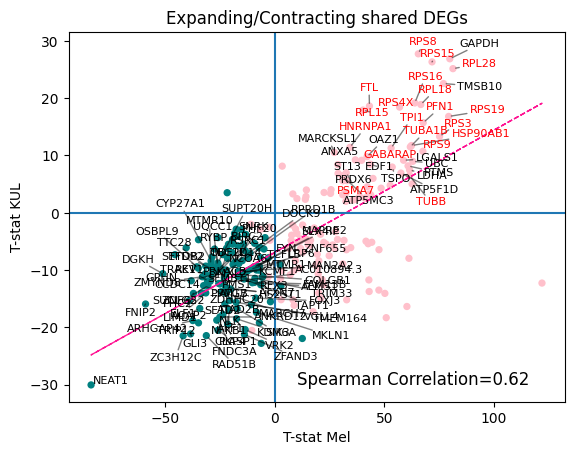

In [122]:
x = lfc_mel["stat"]
y = lfc_kul["stat"]
plt.scatter(x, y, s=18, c=color)

texts = []
for i in lfc_mel.index:
    if (lfc_mel.loc[i]['stat']>6 and lfc_kul.loc[i]['stat']>6 and i in share_degs) or (lfc_mel.loc[i]['stat']<-8 and lfc_kul.loc[i]['stat']<-8 and i in share_degs_sh):
        if i in list(wouters["Immune_resistance_wang"]):
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='red'))
        else:
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black',alpha=.5))

coefficients = np.polyfit(x, y, 1)

spearman_corr, _ = spearmanr(x, y)

# Get the slope and intercept of the fitted line
slope, intercept = coefficients

# Create the line of best fit
y_fit = slope * x + intercept

plt.plot(x, y_fit, color="deeppink", label="Fitted Line", linewidth=1, linestyle="--")

plt.annotate("Spearman Correlation="+str(round(spearman_corr,2)), (10,-30), fontsize=12)


plt.axvline(0)
plt.axhline(0)
#plt.xlim([-80,85])
plt.title("Expanding/Contracting shared DEGs")
plt.xlabel("T-stat Mel")
plt.ylabel("T-stat KUL")
plt.savefig("mel_figures/S2c_KUL_DEGs.pdf")

Text(35.472222222222214, 0.5, 'T-stat KUL')

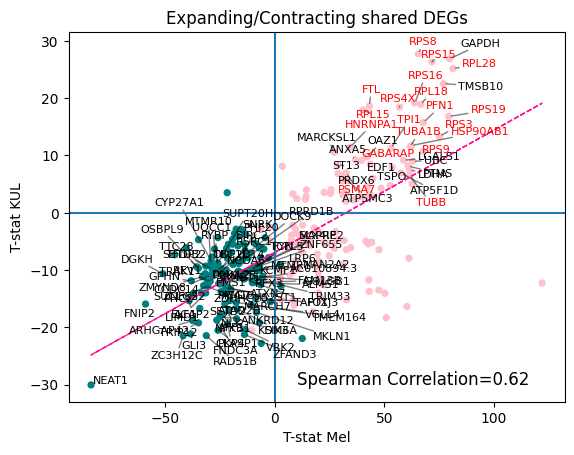

In [121]:
x = lfc_mel["stat"]
y = lfc_kul["stat"]
plt.scatter(x, y, s=18, c=color)

texts = []
for i in lfc_mel.index:
    if (lfc_mel.loc[i]['stat']>6 and lfc_kul.loc[i]['stat']>6 and i in share_degs) or (lfc_mel.loc[i]['stat']<-8 and lfc_kul.loc[i]['stat']<-8 and i in share_degs_sh):
        if i in list(wouters["Immune_resistance_wang"]):
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='red'))
        else:
            texts.append(plt.text(lfc_mel.loc[i]['stat'],lfc_kul.loc[i]['stat'],i, fontsize=8, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black',alpha=.5))

coefficients = np.polyfit(x, y, 1)

spearman_corr, _ = spearmanr(x, y)

# Get the slope and intercept of the fitted line
slope, intercept = coefficients

# Create the line of best fit
y_fit = slope * x + intercept

plt.plot(x, y_fit, color="deeppink", label="Fitted Line", linewidth=1, linestyle="--")

plt.annotate("Spearman Correlation="+str(round(spearman_corr,2)), (10,-30), fontsize=12)


plt.axvline(0)
plt.axhline(0)
#plt.xlim([-80,85])
plt.title("Expanding/Contracting shared DEGs")
plt.xlabel("T-stat Mel")
plt.ylabel("T-stat KUL")